In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Embedding, Multiply, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
(X_train, y_train), (_, _) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # normalize to [-1,1]
X_train = np.expand_dims(X_train, axis=-1)  # shape = (28,28,1)

num_classes = 10
latent_dim = 100

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_generator(latent_dim, num_classes):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(1,), dtype="int32")

    # Embed label
    label_embedding = Embedding(num_classes, latent_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    # Combine noise & label
    model_input = Multiply()([noise_input, label_embedding])

    x = Dense(256)(model_input)
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(28*28*1, activation="tanh")(x)
    img = Reshape((28,28,1))(x)

    return Model([noise_input, label_input], img)

In [4]:
def build_discriminator(num_classes):
    img_input = Input(shape=(28,28,1))
    label_input = Input(shape=(1,), dtype="int32")

    # Embed labels
    label_embedding = Embedding(num_classes, np.prod((28,28,1)))(label_input)
    label_embedding = Flatten()(label_embedding)

    # Flatten image
    flat_img = Flatten()(img_input)

    # Combine image & label
    model_input = Multiply()([flat_img, label_embedding])

    x = Dense(512)(model_input)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    validity = Dense(1, activation="sigmoid")(x)

    return Model([img_input, label_input], validity)

In [5]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator(num_classes)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

generator = build_generator(latent_dim, num_classes)

noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
gen_img = generator([noise, label])

discriminator.trainable = False
validity = discriminator([gen_img, label])

cgan = Model([noise, label], validity)
cgan.compile(loss="binary_crossentropy", optimizer=optimizer)

In [6]:
history = {"d_loss": [], "d_acc": [], "g_loss": []}

def train(epochs=10000, batch_size=64, save_interval=2000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(1, epochs+1):
        # ---- Train Discriminator ----
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict([noise, labels], verbose=0)

        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train Generator ----
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1,1)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch([noise, sampled_labels], real)

        # ---- Store history ----
        history["d_loss"].append(d_loss[0])
        history["d_acc"].append(d_loss[1])
        history["g_loss"].append(g_loss)

        # ---- Print progress ----
        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

        # ---- Save generated images ----
        if epoch % save_interval == 0:
            save_imgs(epoch)


In [7]:
def save_imgs(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    sampled_labels = np.array([num for _ in range(c) for num in range(r)])

    gen_imgs = generator.predict([noise, sampled_labels], verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # rescale to [0,1]

    plt.figure(figsize=(10,2))
    for i in range(r * c):
        plt.subplot(r, c, i+1)
        plt.imshow(gen_imgs[i, :, :, 0], cmap="gray")
        plt.title(f"Digit: {sampled_labels[i]}")
        plt.axis("off")
    plt.suptitle(f"Epoch {epoch}")
    plt.show()


In [8]:
def plot_history():
    plt.figure(figsize=(15,5))

    # Losses
    plt.subplot(1,3,1)
    plt.plot(history["d_loss"], label="Discriminator Loss")
    plt.plot(history["g_loss"], label="Generator Loss")
    plt.title("Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history["d_acc"], label="Discriminator Accuracy")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Combined Loss comparison
    plt.subplot(1,3,3)
    plt.plot(history["d_loss"], label="D Loss")
    plt.plot(history["g_loss"], label="G Loss")
    plt.title("Generator vs Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


500 [D loss: 0.7278, acc: 7.12] [G loss: 0.6354]
1000 [D loss: 0.7360, acc: 6.93] [G loss: 0.6213]


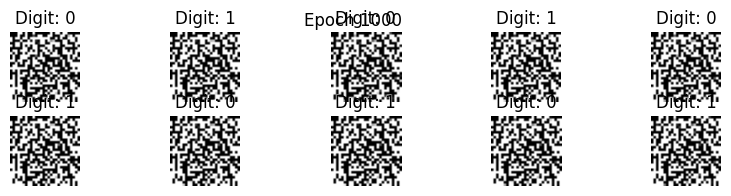

1500 [D loss: 0.7400, acc: 6.93] [G loss: 0.6144]
2000 [D loss: 0.7422, acc: 6.85] [G loss: 0.6108]


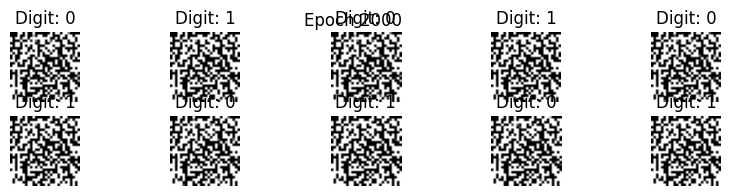

2500 [D loss: 0.7436, acc: 6.83] [G loss: 0.6086]
3000 [D loss: 0.7445, acc: 6.82] [G loss: 0.6070]


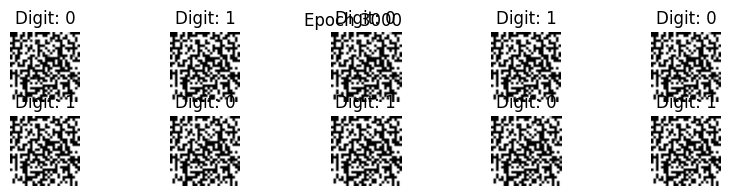

3500 [D loss: 0.7452, acc: 6.80] [G loss: 0.6058]
4000 [D loss: 0.7457, acc: 6.81] [G loss: 0.6050]


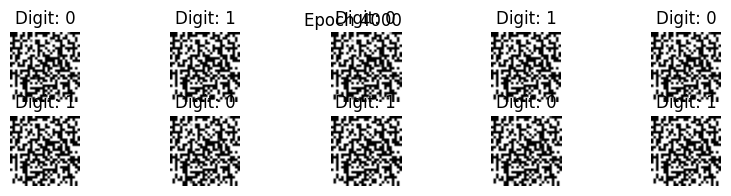

4500 [D loss: 0.7462, acc: 6.80] [G loss: 0.6043]
5000 [D loss: 0.7465, acc: 6.80] [G loss: 0.6037]


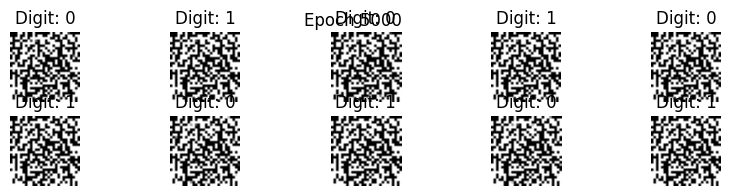

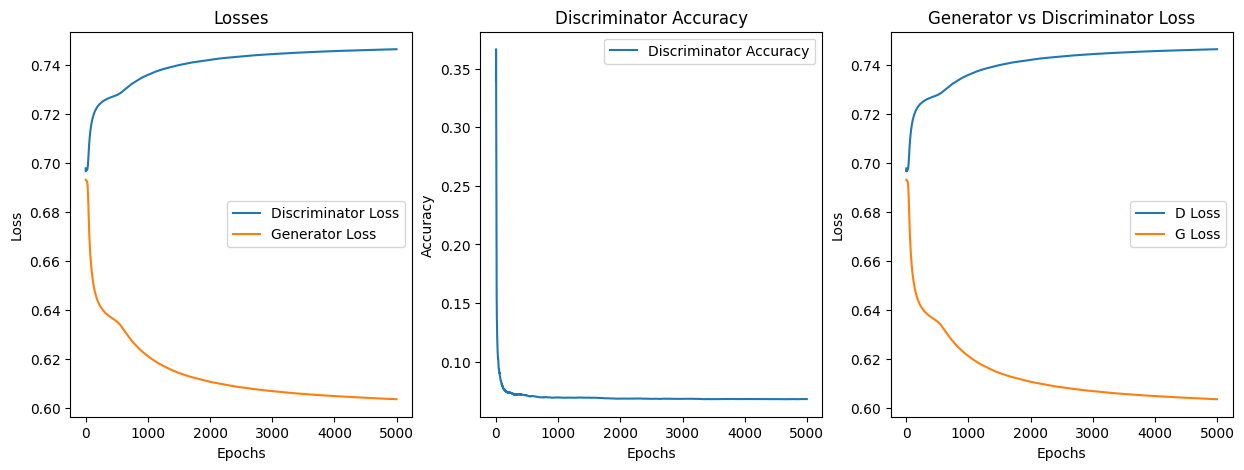

In [9]:
train(epochs=5000, batch_size=64, save_interval=1000)
plot_history()